In [56]:
from utils import*

In [57]:
####################################################################################################################################################
class NODE(object):
    ################################################################################################################################################
    def __init__(self, markers_color, IDD=None, port=None):
        self.markers_color = markers_color
        self.IDD = IDD
        self.port = port
    ################################################################################################################################################
    def load(self, dataset_name, file_name, window_length=11):
        self.load_markers(dataset_name, file_name, window_length=window_length)        
        if self.IDD is not None: self.load_rssi(dataset_name, file_name, window_length=window_length)
        if self.port is not None: self.load_vind(dataset_name, file_name, window_length=window_length)
        return 
    ################################################################################################################################################
    def load_markers(self, dataset_name, file_name, window_length=11):   
      
        # Load raw data 
        markers_file_path = get_markers_file_path(dataset_name, file_name)  
        raw_df  = pd.read_csv(
            markers_file_path,                                                  # relative python path to subdirectory
            usecols = ['time', self.markers_color],                             # Only load the three columns specified.
            parse_dates = ['time'] ) 
        self.markers = pd.DataFrame()

        # DON'T USE!! markers are switched and smoothing causes error    
        # Processing
        # self.markers = self.markers.rolling(window_length, axis=0).mean()    # Gap filling
        # self.markers = self.markers.ffill(axis=0).bfill(axis=0)              # Smoothing

        # Time
        date_time = pd.to_datetime( raw_df['time'] , format=datime_format)
        self.markers['time'] = [ np.round( (datetime.combine(date.min, t.time())-datetime.min).total_seconds(), 2) for t in date_time]
        
        # Markers
        self.markers['markers'] = [list(map(float, l.replace(']','').replace('[','').replace('\n','').split(", "))) for l in raw_df[self.markers_color].values]        
        return
    ################################################################################################################################################
    def load_rssi(self, dataset_name, file_name, window_length=11):
        # Load data 
        rfid_file_path = get_rfid_file_path(dataset_name, file_name)       
        raw_df = pd.read_csv(
            rfid_file_path,                                                     # relative python path to subdirectory
            delimiter  = ';',                                                   # Tab-separated value file.
            usecols = ['IDD', 'Time', 'Ant/RSSI'],                              # Only load the three columns specified.
            parse_dates = ['Time'] )                                            # Intepret the birth_date column as a date      

        # self.rssi.loc[ self.rssi.IDD != self.IDD,'rssi'] = np.nan
        raw_df = raw_df.loc[ raw_df['IDD'] == self.IDD, :]
        self.rssi = pd.DataFrame({ 'rssi': raw_df['Ant/RSSI'].str.replace('Ant.No 1 - RSSI: ', '').astype(int) })

        # Processing
        self.rssi = self.rssi.rolling(window_length, axis=0).median()   # Smoothing
        self.rssi = self.rssi.ffill(axis=0).bfill(axis=0)               # Gap Filling
         
        # Time
        date_time = pd.to_datetime( raw_df['Time'] , format=datime_format)
        self.rssi['time'] = [ np.round( (datetime.combine(date.min, t.time())-datetime.min).total_seconds(), 2) for t in date_time]
        return
    ################################################################################################################################################
    def load_vind(self, dataset_name, file_name, window_length=11):
        # Load data 
        arduino_file_path = get_arduino_file_path(dataset_name, file_name)               
        raw_df = pd.read_csv(arduino_file_path)

        self.vind = raw_df

        # Processing
        self.vind = self.rssi.rolling(window_length, axis=0).median()   # Smoothing
        self.vind = self.rssi.ffill(axis=0).bfill(axis=0)               # Gap Filling
         
        # Time
        date_time = pd.to_datetime( raw_df['time'] , format=datime_format)
        self.vind['time'] = [ np.round( (datetime.combine(date.min, t.time())-datetime.min).total_seconds(), 2) for t in date_time]
        return
    ################################################################################################################################################
    def shift_time(self, shift):
        self.markers.time -= shift
        if self.IDD is not None: self.rssi.time -= shift
        if self.port is not None: self.rssi.time -= shift
        return
    ################################################################################################################################################
    def center(self, window_length=7, polyorder=1):
        markers_npy = self.markers.drop(['time'], axis=1).to_numpy()
        markers_npy = markers_npy.reshape(np.shape(markers_npy)[0], -1, 3)
        center = np.mean(markers_npy, axis=1) 
        
        center = np.nan_to_num(center)
        center = signal.savgol_filter( center, window_length=window_length, polyorder=polyorder, axis=0)            
        return center
    ################################################################################################################################################    
    def norm(self, window_length=7, polyorder=1):
        markers_npy = self.markers.drop(['time'], axis=1).to_numpy()

        markers_npy =  markers_npy.reshape(np.shape(markers_npy)[0], -1, 3)
        v1 = markers_npy[:,1,:] - markers_npy[:,0,:]
        v2 = markers_npy[:,2,:] - markers_npy[:,0,:] 
        norm = np.cross( v1, v2)
        # norm[ norm[:,2]<0, :] *= -1 

        # norm = np.nan_to_num(norm)
        # norm = signal.savgol_filter( norm, window_length=window_length, polyorder=polyorder, axis=0)  
        norm = norm / ( np.reshape(np.linalg.norm(norm, axis=1), (-1,1)) * np.ones((1,3))) 
        return norm
####################################################################################################################################################
####################################################################################################################################################
class SYSTEM(object):
    ################################################################################################################################################
    def __init__(self, system_info = None):
        self.reader = None
        self.tags = list()

        if system_info is not None:
            system_info_ = system_info.copy()
            reader_markers_color = system_info_.pop('reader')
            self.add_reader(reader_markers_color)
            for IDD,markers_color in system_info_.items(): self.add_tag(markers_color, IDD)
        return
    ################################################################################################################################################
    def add_reader(self, reader_markers_color):
        self.reader = NODE( reader_markers_color )
        return
    ################################################################################################################################################
    def add_tag(self, markers_color, IDD=None, port=None):
        self.tags.append( NODE(markers_color, IDD=IDD, port=port) )   
        return               
    ################################################################################################################################################
    def load(self, dataset_name, file_name):
        self.dataset_name = dataset_name
        self.file_name = file_name

        # Loading + time shift
        self.reader.load(dataset_name, file_name) 
        start_time = self.reader.markers.time.iloc[0]

        for i,tag in enumerate(self.tags):            
            self.tags[i].load(dataset_name, file_name)
            start_time = min( start_time, tag.rssi.time.iloc[0])

        self.reader.shift_time(start_time)    
        for i,tag in enumerate(self.tags): self.tags[i].shift_time(start_time)
        
        return
    ################################################################################################################################################
    def get_rssi_data(self, window_length=11, polyorder=1):
        rssi = pd.DataFrame({'time':self.tags[0].rssi.time})
        for i, tag in enumerate(self.tags):
            tag_rssi = sys.tags[i].rssi.rename({'rssi':'rssi_'+str(i)}, axis=1)
            rssi = rssi.merge( tag_rssi, on='time', how='outer', suffixes=('', ''), sort=True )               
 
        # RSSI data status
        status = pd.DataFrame({'time':rssi.time})
        for column in rssi.columns:
            if column != 'time': status[column.replace('rssi','status')] = np.isnan(rssi[column].values)
        
        # # Smoothing
        rssi.loc[:, rssi.columns != 'time'] = rssi.loc[:, rssi.columns != 'time'].rolling(window_length, axis=0).mean().fillna(method='ffill', axis=0).bfill(axis=0)      
        for col in rssi.columns:
            if col != 'time': rssi.loc[:,col]= signal.savgol_filter( rssi.loc[:,col], window_length=window_length, polyorder=polyorder) 

        return rssi, status       
    ################################################################################################################################################
    def get_motion_data(self, window_length=11, polyorder=1):   
        # Modify this function for different targeted movements
        motion = pd.DataFrame({'time':self.reader.markers.time})

        N = 10
        ref_center = self.reader.center()
        ref_center = np.ones(np.shape(ref_center)) * np.mean(ref_center[:N], axis=0)

        ref_norm = self.reader.norm()     
        ref_norm =  np.mean(ref_norm[:N], axis=0)
        ref_norm = ref_norm / np.linalg.norm(ref_norm)
        ref_norm = np.ones(np.shape(ref_norm)) * ref_norm

        
        for i, tag in enumerate(self.tags):
            distance_vec = ref_center - tag.center()
            distance = np.linalg.norm( distance_vec, axis=1)
            lat_misalignment = np.sqrt(distance**2 - np.sum(np.multiply( distance_vec, ref_norm), axis=1)**2)           
            ang_misalignment = np.arcsin( np.linalg.norm(np.cross(ref_norm, tag.norm()), axis=1) )*180/np.pi
            
            motion['distance_'+str(i)] = signal.savgol_filter( distance, window_length=window_length, polyorder=polyorder, axis=0)                        
            motion['lat_misalignment_'+str(i)] = signal.savgol_filter( lat_misalignment, window_length=window_length, polyorder=polyorder, axis=0)        
            motion['ang_misalignment_'+str(i)] = signal.savgol_filter( ang_misalignment, window_length=window_length, polyorder=polyorder, axis=0)        

        # ang_misalignment = np.arcsin( np.mean([ np.linalg.norm(np.cross(ref_norm, tag.norm()), axis=1) for tag in self.tags],0) )*180/np.pi
        # motion['ang_misalignment'] = signal.savgol_filter( ang_misalignment, window_length=window_length, polyorder=polyorder, axis=0)        

        return motion
    ################################################################################################################################################
    def get_data(self, window_length=11, save=False,  data_status=False):
        rssi, status = self.get_rssi_data()
        motion = self.get_motion_data()       
    
        data = pd.DataFrame({'time':rssi.time})
        data = data.merge( motion, on='time', how='outer', suffixes=('', ''), sort=True )
        data = data.interpolate(method='nearest')        
        data.loc[:, data.columns!='time'] = data.loc[:, data.columns!='time'].rolling(window_length, axis=0).mean().fillna(method='ffill', axis=0).bfill(axis=0)      
        
        data = data.merge(rssi, on='time', how='inner', suffixes=('', ''), sort=True)
        data = data.merge(status, on='time', how='inner', suffixes=('', ''), sort=True)

        time = rssi.time
        time = time[ motion.time.iloc[0] < time]
        time = time[ time < motion.time.iloc[-1] ]
        data = data.merge( time, on='time', how='inner', suffixes=('', ''), sort=True )

        if save:
            dataset_file_path = get_dataset_file_path(self.dataset_name, self.file_name)
            create_folder(dataset_file_path)
            data.to_pickle( dataset_file_path )  
            print(self.file_name, 'is saved.')
        return data
####################################################################################################################################################


In [58]:
dataset_name = 'dataset_04'
file_name = 'record_' + "{0:0=2d}".format(0)

In [48]:
# arduino_file_path = get_arduino_file_path(dataset_name, file_name)               
# raw_df = pd.read_csv(arduino_file_path)
# raw_df['/dev/cu.usbserial-1420']

In [53]:
# node = NODE('red', port ='/dev/cu.usbserial-1420')
node = NODE('red', IID='')

node.load_vind(dataset_name, file_name)
node.vind

,vind,time
0,3.530273,64908.83
1,3.530273,64908.84
2,3.530273,64908.84
3,3.530273,64908.84
4,3.530273,64908.85
5,3.530273,64908.85
6,3.530273,64908.87
7,3.530273,64908.87
8,3.530273,64908.87
9,3.530273,64908.88


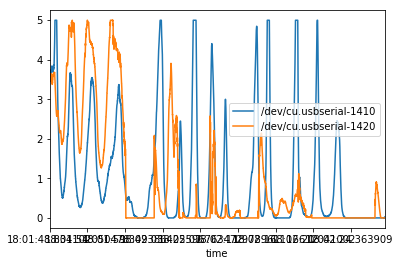

In [54]:
ax = vind.plot(x='time', y='/dev/cu.usbserial-1410')
vind.plot(x='time', y='/dev/cu.usbserial-1420', ax=ax)
plt.show()

In [ ]:
# dataset_name = 'dataset_00'

# time_folder_path = main_directory + '/dataset/' + dataset_name + '/kinect/time'
# markers_folder_path = main_directory + '/dataset/' + dataset_name + '/kinect/markers'

# for n in range(30):
#     file_name = 'record_' + "{0:0=2d}".format(n)
    
#     time_file_path = time_folder_path + '/' + file_name + '.txt'   
#     with open(time_file_path , 'r') as f:  lines = f.read().splitlines() 
#     date_time = pd.to_datetime( lines , format=datime_format)
#     time = pd.DataFrame({'time':[t.time() for t in date_time]})
             
#     locations_dict_ = dict()
#     for color in ['red','blue','green']:
#         markers_file_path = markers_folder_path + '/' + file_name + '_' + color +'.txt' 
#         locations = pd.read_csv( markers_file_path, delimiter="\t", header=None, dtype=np.float64).to_numpy()
# #         locations_dict_.update({color: locations})
#         locations_dict_.update({color: list(map(list,locations))})
    
#     locations_dict = defaultdict(list)  
#     for l in range(len(time)):
#         for color in ['red','blue','green']:
#             locations_dict[color].append( locations_dict_[color][l] )                            

#   # MArkers (time and locations)
#     markers = pd.concat([time, pd.DataFrame(locations_dict)], axis=1)

#     # Save 
#     markers_file_path = get_markers_file_path(dataset_name, file_name)
#     create_folder(markers_file_path)
#     markers.to_csv(markers_file_path, index=False)
        